In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns=None
pd.options.mode.chained_assignment = None

In [3]:
actions = pd.read_csv(r'C:\Users\User\apr_test\actions.csv')

In [4]:
triggers = pd.read_csv(r'C:\Users\User\triggers\triggers.csv')

In [ ]:
triggers['type'].value_counts()

In [ ]:
triggers['trigger'].nunique()

In [31]:
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378204 entries, 0 to 378203
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   guid    378204 non-null  object        
 1   date    378204 non-null  datetime64[ns]
 2   result  378204 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 8.7+ MB


In [ ]:
triggers.info()

In [ ]:
# приведём даты к верному типу
actions['date'] = pd.to_datetime(actions['date'], errors='coerce')
triggers['date'] = pd.to_datetime(triggers['date'], errors='coerce')

In [ ]:
# предобработка данных 
print(actions.isnull().sum())
print(triggers.isnull().sum())

In [5]:
print("Количество дубликатов в 'actions':", actions.duplicated().sum())
print("Количество дубликатов в 'triggers':", triggers.duplicated().sum())

Количество дубликатов в 'actions': 0
Количество дубликатов в 'triggers': 5933568


In [ ]:
# больше 10% полных дубликтов, если это не ошибка в записи данных, это может означать, что пользователь несколько раз нажимает
# куда-то, пока что построим модель, удалив дубликаты, но в дальнейшем это можно будет отдельно проанализировать и возможно добавить в модель
triggers_duplicates.head(5)

In [13]:
triggers = triggers.drop_duplicates(keep='first')

In [ ]:
# как связаные trigger type и action 
# проверим могут быть для одного и того же триггера повторяющиеся type
# если нет, то буду расценивать type как только такой возможный тип взаимодействия для этого тригера 

In [14]:
trigger_type_check = triggers.groupby('trigger')['type'].nunique().reset_index()

In [15]:
trigger_type_check.head()

,trigger,type
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [16]:
trigger_type_check['type'].value_counts()

type
1    2330
2     177
Name: count, dtype: int64

In [17]:
trigger_with_multiple_types = trigger_type_check[trigger_type_check['type'] > 1]

In [18]:
trigger_with_multiple_types.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177 entries, 17 to 2473
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   trigger  177 non-null    int64
 1   type     177 non-null    int64
dtypes: int64(2)
memory usage: 4.1 KB


In [ ]:
# получается что в текущей модели у 177 тригеров возможны разные типы взаимодействия, большинство триггеров 
# вызывают один и тот же тип взаимодействия 

In [ ]:
# объединение данных по guid, чтобы сопоставить действия с триггерами одного пользователя
merged_data = pd.merge(triggers, actions[['guid', 'date', 'result']], on='guid', how='inner')

# фильтрация триггеров, которые произошли до действия
merged_data = merged_data[merged_data['date_x'] <= merged_data['date_y']]


# сортировка по guid и дате действия
merged_data = merged_data.sort_values(by=['guid', 'date_y', 'date_x'])

# Для каждого действия выбираем последний триггер до действия (максимальную дату триггера)
closest_trigger = merged_data.groupby(['guid', 'date_y']).tail(1).reset_index(drop=True)
# Переименуем столбцы для удобства
closest_trigger = closest_trigger.rename(columns={'date_x': 'date', 'date_y': 'action_date'})
triggers_actions = pd.merge(triggers,closest_trigger,how='left',on = ['guid','date','trigger','type'])

### объединим данные так, чтобы каждая строка из action попадала в точный интервал в triggers 

In [21]:
# объединение данных по guid, чтобы сопоставить действия с триггерами одного пользователя
merged_data = pd.merge(triggers, actions[['guid', 'date', 'result']], on='guid', how='inner')

In [22]:
merged_data.head()

,guid,date_x,trigger,type,date_y,result
0,0187a472-becb-7994-5e1e-f179b60bc141,2024-05-31 23:55:27,168,2,2024-05-17 12:19:25,0
1,018ba175-9e02-8c7a-e522-6e5fec6949a0,2024-05-31 23:55:26,1807,2,2024-05-28 01:41:41,0
2,018ba175-9e02-8c7a-e522-6e5fec6949a0,2024-05-31 23:55:26,1807,2,2024-05-13 02:30:31,0
3,018ba175-9e02-8c7a-e522-6e5fec6949a0,2024-05-31 23:55:26,2048,2,2024-05-28 01:41:41,0
4,018ba175-9e02-8c7a-e522-6e5fec6949a0,2024-05-31 23:55:26,2048,2,2024-05-13 02:30:31,0


In [23]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42659807 entries, 0 to 42659806
Data columns (total 6 columns):
 #   Column   Dtype         
---  ------   -----         
 0   guid     object        
 1   date_x   datetime64[ns]
 2   trigger  int64         
 3   type     int64         
 4   date_y   datetime64[ns]
 5   result   int64         
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 1.9+ GB


In [24]:

# фильтрация триггеров, которые произошли до действия
merged_data = merged_data[merged_data['date_x'] <= merged_data['date_y']]


In [25]:

# сортировка по guid и дате действия
merged_data = merged_data.sort_values(by=['guid', 'date_y', 'date_x'])

In [26]:
merged_data.head(5)

,guid,date_x,trigger,type,date_y,result
34268426,0187808f-1de0-735d-6e69-0d52a09fcd76,2024-05-07 06:52:06,1808,2,2024-05-07 06:57:39,0
34268427,0187808f-1de0-735d-6e69-0d52a09fcd76,2024-05-07 06:52:06,1808,2,2024-05-23 04:42:12,0
33502992,0187808f-1de0-735d-6e69-0d52a09fcd76,2024-05-07 13:35:29,1808,2,2024-05-23 04:42:12,0
32889095,0187808f-1de0-735d-6e69-0d52a09fcd76,2024-05-08 05:52:43,1807,2,2024-05-23 04:42:12,0
32656831,0187808f-1de0-735d-6e69-0d52a09fcd76,2024-05-08 07:39:45,1808,2,2024-05-23 04:42:12,0


In [27]:

# для каждого действия выбираем последний триггер до действия (максимальную дату триггера)
closest_trigger = merged_data.groupby(['guid', 'date_y']).tail(1).reset_index(drop=True)

In [28]:
closest_trigger.head()

,guid,date_x,trigger,type,date_y,result
0,0187808f-1de0-735d-6e69-0d52a09fcd76,2024-05-07 06:52:06,1808,2,2024-05-07 06:57:39,0
1,0187808f-1de0-735d-6e69-0d52a09fcd76,2024-05-23 04:38:40,2074,2,2024-05-23 04:42:12,0
2,0187808f-53e2-ffd9-7d4f-0f6c5ee0396b,2024-05-07 06:12:52,2053,2,2024-05-07 06:16:09,0
3,01878092-1c9f-ac2f-c22e-de13adca7008,2024-05-02 11:56:32,159,1,2024-05-02 11:59:50,0
4,01878092-4b24-e102-7a09-8029282ee35f,2024-05-18 07:35:37,224,1,2024-05-18 07:36:20,0


In [29]:
# переименуем столбцы для удобства
closest_trigger = closest_trigger.rename(columns={'date_x': 'date', 'date_y': 'action_date'})

In [30]:

# проверка количества сопоставленных строк
print(f"Количество сопоставленных действий и триггеров: {closest_trigger.shape[0]}")


Количество сопоставленных действий и триггеров: 378202


In [ ]:
# теперь заменим строки в полной таблице с триггерами на полученные строки с результатом, так мы увидим
# полную картину со всеми тригерами, фактом совершения или не совершения действия и результатом этого действия 

In [32]:
triggers_actions = pd.merge(triggers,closest_trigger,how='left',on = ['guid','date','trigger','type'])

In [33]:
triggers_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37141059 entries, 0 to 37141058
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   guid         object        
 1   date         datetime64[ns]
 2   trigger      int64         
 3   type         int64         
 4   action_date  datetime64[ns]
 5   result       float64       
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 1.7+ GB


In [34]:
triggers_actions.head(10)

,guid,date,trigger,type,action_date,result
0,018bdd75-83fc-2510-50e7-153f7b5e4b64,2024-05-31 23:55:27,2047,2,NaT,NaN
1,0187a472-becb-7994-5e1e-f179b60bc141,2024-05-31 23:55:27,168,2,NaT,NaN
2,018ba175-9e02-8c7a-e522-6e5fec6949a0,2024-05-31 23:55:26,1807,2,NaT,NaN
3,018ba175-9e02-8c7a-e522-6e5fec6949a0,2024-05-31 23:55:26,2048,2,NaT,NaN
4,018e9cfb-c8bc-f38b-e209-5a77c5324a14,2024-05-31 23:55:26,1773,2,2024-05-31 23:57:14,0.0
5,018cd401-9d7d-7835-2b4c-bd9bdf2cfee5,2024-05-31 23:55:26,2049,2,NaT,NaN
6,018ba19b-b5a2-7925-1b99-ca029f962425,2024-05-31 23:55:26,1767,2,NaT,NaN
7,01879181-97e9-e649-8770-917f5cca1e81,2024-05-31 23:55:26,2050,2,2024-05-31 23:57:14,0.0
8,018ba16d-19e8-2b2d-c722-ec9cfcf82fe0,2024-05-31 23:50:32,2051,2,NaT,NaN
9,018bf165-e1a4-1195-c3c5-eecddda50648,2024-05-31 23:50:32,243,2,NaT,NaN


In [ ]:
# проверим частоту взаимодействий в текущей модели

In [35]:
closest_trigger_sorted = closest_trigger.sort_values(by=['guid', 'action_date'])


In [36]:
closest_trigger_sorted['action_date'] = pd.to_datetime(closest_trigger_sorted['action_date'], errors='coerce')

In [39]:

# вычисляем временные интервалы между взаимодействиями
closest_trigger_sorted['time_diff'] = closest_trigger_sorted.groupby('guid')['action_date'].diff()


In [40]:
closest_trigger_sorted.head()

,guid,date,trigger,type,action_date,result,time_diff
0,0187808f-1de0-735d-6e69-0d52a09fcd76,2024-05-07 06:52:06,1808,2,2024-05-07 06:57:39,0,NaT
1,0187808f-1de0-735d-6e69-0d52a09fcd76,2024-05-23 04:38:40,2074,2,2024-05-23 04:42:12,0,15 days 21:44:33
2,0187808f-53e2-ffd9-7d4f-0f6c5ee0396b,2024-05-07 06:12:52,2053,2,2024-05-07 06:16:09,0,NaT
3,01878092-1c9f-ac2f-c22e-de13adca7008,2024-05-02 11:56:32,159,1,2024-05-02 11:59:50,0,NaT
4,01878092-4b24-e102-7a09-8029282ee35f,2024-05-18 07:35:37,224,1,2024-05-18 07:36:20,0,NaT


In [41]:

# Анализируем, сколько раз взаимодействие с пользователями происходило менее чем через 2 недели
too_frequent_interactions = closest_trigger_sorted[closest_trigger_sorted['time_diff'] < pd.Timedelta(weeks=2)]


In [42]:
# в текущей модели нет взаимоействий чаще, чем раз в две недели
too_frequent_interactions.shape

(0, 7)

In [43]:
# анализ эффективности типов взаимодействий 
# подсчет количества успешных взаимодействий по каждому типу
type_success_rate = closest_trigger_sorted.groupby('type')['result'].agg(['count', 'sum'])

In [44]:

# рассчитываем процент успешных взаимодействий
type_success_rate['success_rate'] = type_success_rate['sum'] / type_success_rate['count']

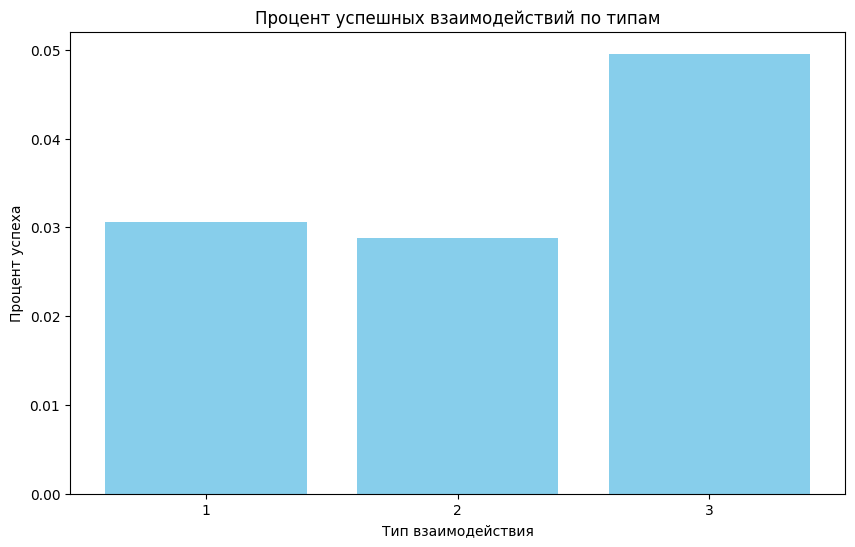

In [51]:
plt.figure(figsize=(10, 6))
plt.bar(type_success_rate.index, type_success_rate['success_rate'], color='skyblue')
plt.title('Процент успешных взаимодействий по типам')
plt.xlabel('Тип взаимодействия')
plt.ylabel('Процент успеха')
plt.xticks(type_success_rate.index)
plt.show()

In [ ]:
# из-за большой разницы в количестве взаимодействий взвесим разные типы 

In [45]:
# считаем общее количество взаимодействий
total_interactions = type_success_rate['count'].sum()

# Рассчитываем долю каждого типа взаимодействия
type_success_rate['interaction_share'] = type_success_rate['count'] / total_interactions

# Пересчитываем взвешенный успех с учетом доли использования
type_success_rate['weighted_success_rate'] = type_success_rate['success_rate'] * type_success_rate['interaction_share']



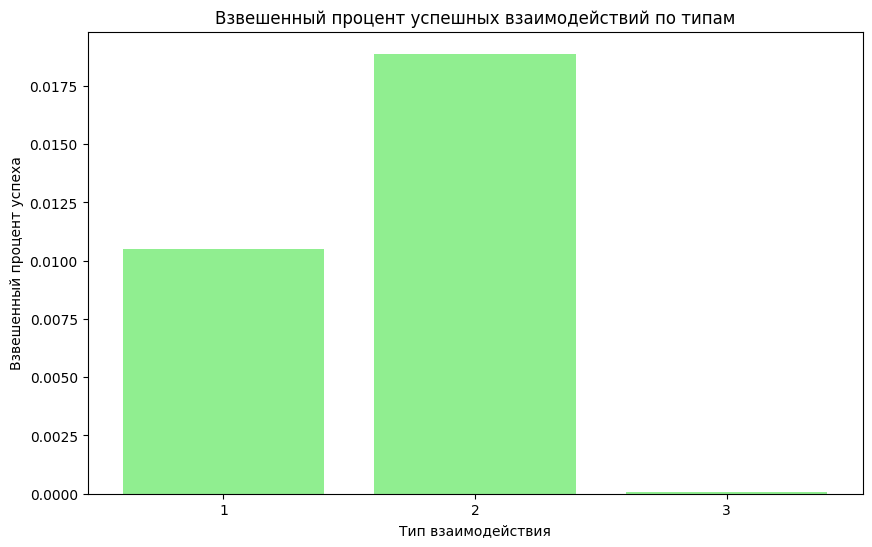

In [48]:
plt.figure(figsize=(10, 6))
plt.bar(type_success_rate.index, type_success_rate['weighted_success_rate'], color='lightgreen')
plt.title('Взвешенный процент успешных взаимодействий по типам')
plt.xlabel('Тип взаимодействия')
plt.ylabel('Взвешенный процент успеха')
plt.xticks(type_success_rate.index)
plt.show()


In [55]:
# получается третий тип используется реже всего, но относительно количества использований он самый успешный
# сохраняю датафрейм, чтобы перейти к подготовке признаков и дальнейшему анализу 
triggers_actions.to_csv(r'C:\Users\User\triggers\triggers_actions.csv',index = False)